# **EEG Signals to Spectrogram Images with CRNN Model**


![image](https://user-images.githubusercontent.com/68053788/223537888-84db529f-b165-4f69-97d2-4cf7b8c9afc9.png)



To convert EEG signals to spectrogram images, we can use the Short-Time Fourier Transform (STFT) which is a commonly used technique in signal processing. The STFT works by dividing the signal into small windows and then performing a Fourier Transform on each window. This results in a time-frequency representation of the signal, which we can then visualize as a spectrogram.


![image](https://user-images.githubusercontent.com/68053788/223547394-b5e9c133-1c71-4c50-abb4-a5102fb67a96.png)

In [ ]:
import numpy as np
from scipy import signal

nperseg = 16  # number of samples per segment
noverlap = nperseg // 2  # number of samples overlapping between segments
fs = 32 # fs is the sampling frequency
spec_list = []

# Compute spectrogram for each segment of the data
for i in range(eeg_data.shape[1] - nperseg + 1):
    segment = eeg_data[:, i:i+nperseg].T  # transpose to match signal.spectrogram's input shape
    f, t, spec = signal.spectrogram(segment, fs=fs, nperseg=nperseg, noverlap=noverlap)
    spec = np.log(spec + 1e-7)  # normalize the spectrogram
    spec_list.append(spec)

# Concatenate the spectrograms for each segment into a single array
spec = np.concatenate(spec_list, axis=1)

# Normalize the spectrogram to [0, 1]
spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))

# Reshape the spectrogram into an image with shape (freq_bins, time_bins, 1)
spec = np.expand_dims(spec, axis=-1)


Once we have our spectrogram images, we can apply Convolutional Recurrent Neural Networks (CRNNs) to classify the EEG signals. CRNNs are a type of neural network that combines the spatial learning of convolutional neural networks (CNNs) with the temporal learning of recurrent neural networks (RNNs).

![-g001](https://user-images.githubusercontent.com/68053788/223549421-748c6df8-303e-436a-90ba-be49740986a6.jpg)

![Structure-of-the-hybrid-DNNs-The-EEG-time-series-generates-6-RGB-images-The-images_W640](https://user-images.githubusercontent.com/68053788/223579749-2da49df9-0219-4abd-8164-8e5c034502ed.jpg)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten, Dropout
from tensorflow.keras.models import Model

# input_shape should be (freq_bins, time_bins, 1)
input_shape = (32, 32, 1)

# define the model
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

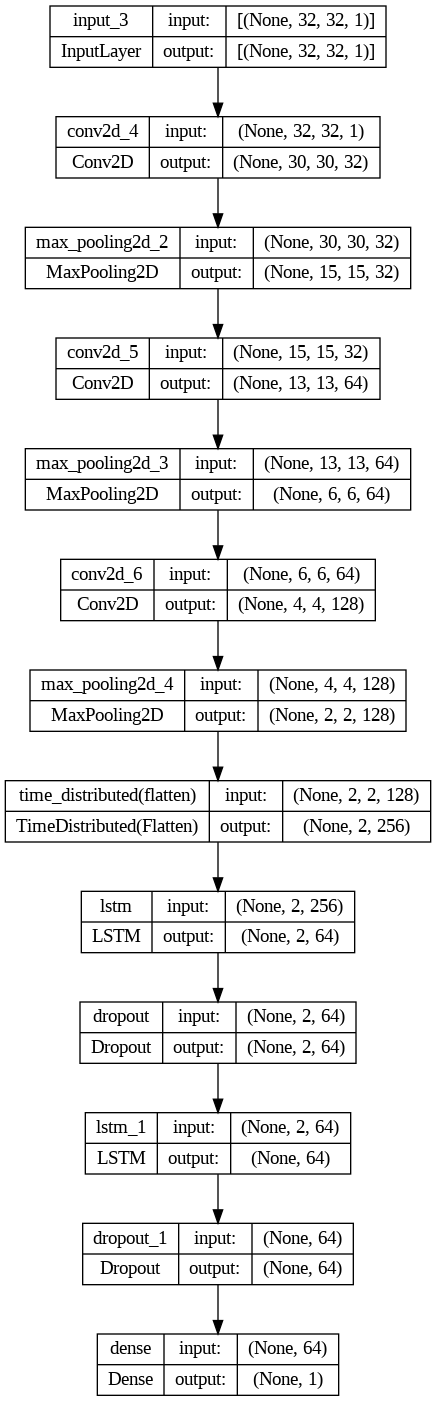

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='spectrogram_CRNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=batch_size)

In the above code, we define a CRNN model that takes in spectrogram images as input and outputs a classification result. The model consists of convolutional layers to learn spatial features from the spectrogram images, followed by LSTM layers to learn temporal features. The TimeDistributed layer is used to apply the same set of convolutions to each timestep of the spectrogram image.

Once we have trained our CRNN model, we can evaluate its performance on a test set and generate a confusion matrix to visualize its performance on each class.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# evaluate the model on the test set
loss, acc = model.evaluate(x_test, y_test)

# generate predictions on the test set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# generate a classification report
cr = classification_report(y_true, y_pred)
print(cr)